## Useful imports

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

from src.preprocessing import preprocessing, load_data, data_diabetes, visualize

# Style des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## Charging the csv in a dataframe

First step is to take a look at the data to know what we are dealing with.

We charge the csv in a panda dataframe and apply multiple methods to visualize the data.

A quick search to the source of the data (https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?select=diabetes_binary_health_indicators_BRFSS2015.csv) gives us the information on the meaning of the data and precisions on the features.

In [3]:
data = data_diabetes

print("Chargement et preprocessing des données...")
samples = preprocessing(data=data, test_size=0.15, validation_size=0.15)

X, _, df, feature_names = load_data(data)
feature_names.remove('Class')

print(f"Nombre total de patients: {len(X)}")
print(f"Training set: {len(samples.X_train)} samples")
print(f"Test set: {len(samples.X_test)} samples")
print(f"Features: {len(feature_names)}")

df

Chargement et preprocessing des données...
Nombre total de patients: 253680
Training set: 177576 samples
Test set: 38052 samples
Features: 21


,Class,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
219620,0.0,0.0,0.0,1.0,21.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,3.0,3.0,7.0,0.0,0.0,7.0,4.0,2.0
132821,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,0.0,13.0,6.0,6.0
151862,0.0,0.0,0.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,4.0,7.0
139717,0.0,0.0,0.0,1.0,27.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,2.0,3.0,0.0,0.0,1.0,2.0,4.0,7.0
239235,0.0,0.0,1.0,1.0,31.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,4.0,27.0,27.0,1.0,0.0,8.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,0.0,1.0,0.0,1.0,45.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,15.0,0.0,0.0,0.0,5.0,4.0,1.0
103694,0.0,1.0,1.0,1.0,29.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,11.0,6.0,7.0
131932,0.0,0.0,1.0,1.0,25.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,3.0,0.0,0.0,9.0,6.0,8.0
146867,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,2.0,0.0,0.0,0.0,0.0,5.0,6.0,6.0


253680 different patients and 21 features.

Most of the features are binary : 1.0 if true and 0.0 if false.

Couple exemples : 
- **"Diabetes_binary** : if the patient has diabetes.
- **"Fruits"** : if the patient eats at least one fruit a day.
- **"PhysHlth"** : if the patient practiced a physical activity in the last 30 days.
- **"Smoker"** : if the patient had more than 100 cigarettes (5 packs) in his life
- **"HighBP"** : high blood pressure

**"Sex"** is 0.0 for female and 1.0 for male

Some features have numerical values :
- **"BMI"** : Body Mass Index : weight(kg) / height(m)t^2 (18.5 to 24.9 is "normal", 25 to 29.9 is "overweight")
- **"MentHlth"** : Days of poor mental health on a 1 to 30 days scale
- **"Age"** : Using the 13-level age category -> 1 = 18-24 | 9 = 60-64 | 13 = 80 
- **"Education"** : level of studies -> 0 = never attended school or only kindergarden etc...
- **"Income"** : level of income on a 1 to 8 scale (in dollars) -> 1 = less than 10,000 | 5 = less than 35,000 | 8 = 75,000 or more

In [4]:
df.describe()

,Class,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.139333,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.346294,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


For binary features, the mean acts as a computation of the percentage of the patients which validate it.

A quick look at the means of the different binary features shows for exemple that most of the patients had a cholesterol check in the last 5 years (0.96), that around half of them smoke (0.44) and that around 14% of them has diabetes (0.139)

We can print exactly the number of patient having diabetes :

In [5]:
df["Class"].value_counts()

Class
0.0    218334
1.0     35346
Name: count, dtype: int64

It is interesting to see the correlation between features. Here we choose features that seems more relevant than others to determine if a patient has diabetes to keep the correlation matrix readable.

affichage de la matrice de corrélation


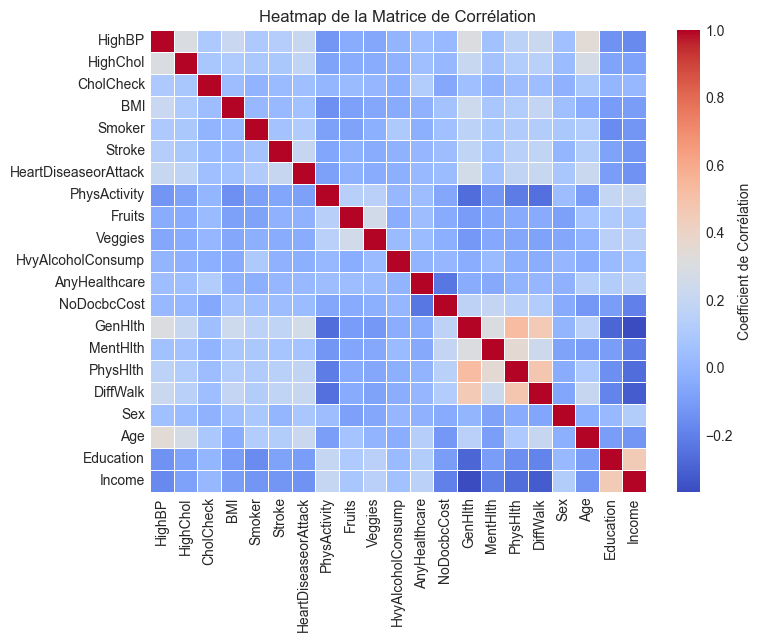

In [6]:
visualize(data_diabetes, selected_features=[], random=True)

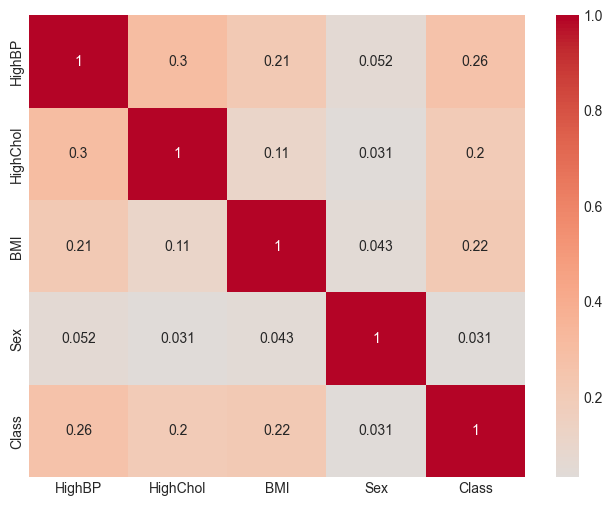

In [7]:
relevant_features = ["HighBP", "HighChol", "BMI", "Sex", "Class"]
corr = df[relevant_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.show()

We can see the distribution of each feature on diabetics and no diabetics

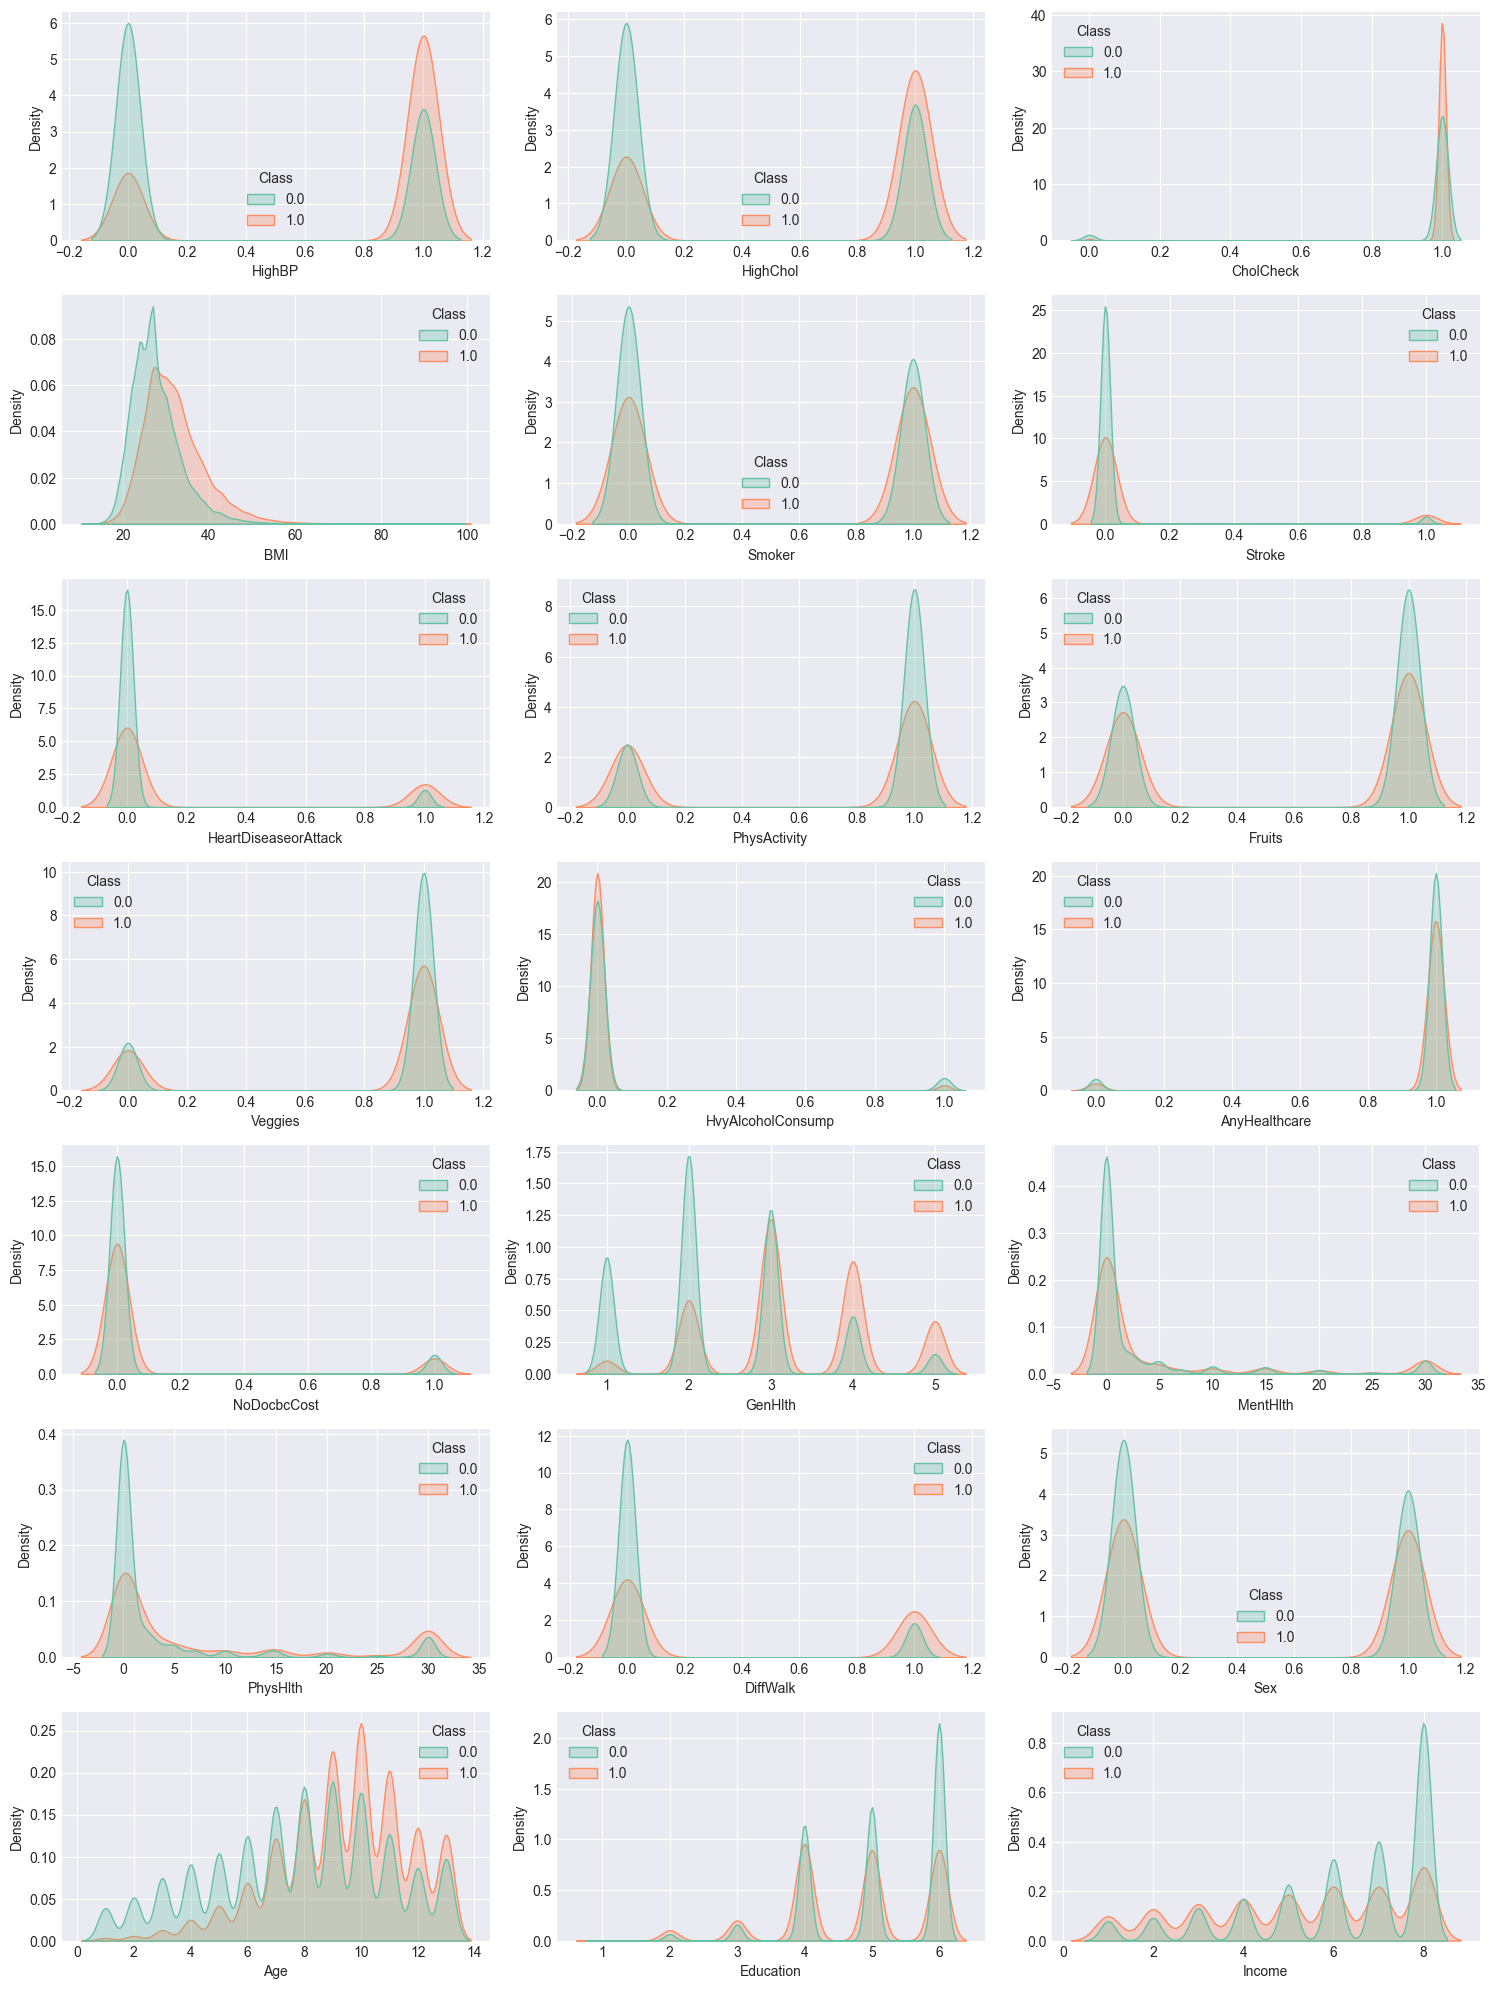

In [8]:
fig, axes = plt.subplots(7, 3, figsize=(15, 20))
axes = axes.flatten()
for idx, feature in enumerate(df.columns[1:]):
    sns.kdeplot(
        data=df, x=feature, hue="Class", ax=axes[idx], fill=True, palette="Set2", alpha=0.3, common_norm=False
    )
    axes[idx].grid(True)
plt.tight_layout()
plt.show()

## Analysis

# K nearest neighbour


The first algorithm we decide to use is the KNN algorithm as it is easy and quick to implement.

In [9]:
from src.knn import KNNModel

samples = preprocessing(data=data_diabetes, test_size=0.3, validation_size=0.1)

model_knn = KNNModel()
MODEL_PATH = "model_weights/best_KNN.joblib"

# Tenter de charger le modèle
if not model_knn.load_model(MODEL_PATH):
    # Si le chargement échoue (première fois ou fichier manquant), entraîner
    print("Modèle non trouvé, lancement de l'entraînement...")
    model_knn.train(samples.X_train, samples.y_train)
    # Sauvegarder après l'entraînement
    model_knn.save_model(MODEL_PATH)
else:
    print("Modèle déjà entraîné chargé.")

 Erreur: Fichier non trouvé à best_KNN.joblib
Modèle non trouvé, lancement de l'entraînement...
 Modèle KNN sauvegardé dans best_KNN.joblib


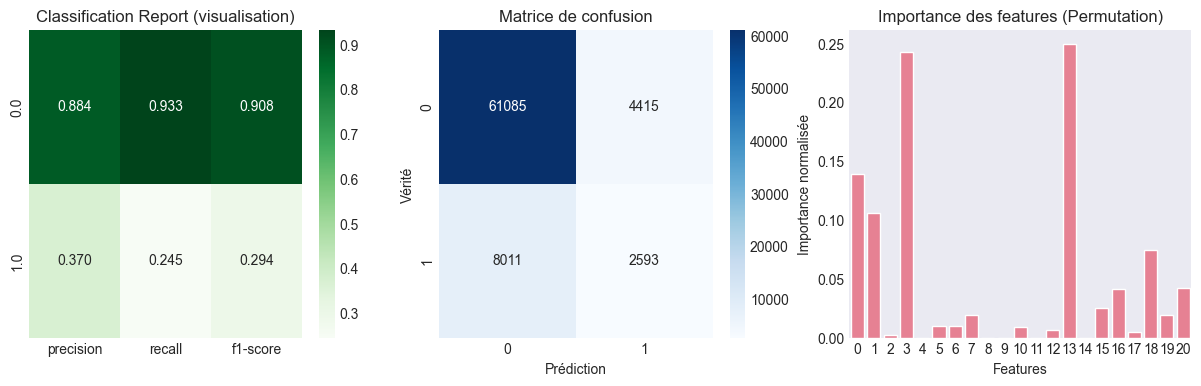

In [11]:
model_knn.benchmark(x=samples.X_test, y=samples.y_test)

We have the best results for K = 3.     
At first sight, the results seem very good : for the non-diabetic people the precision is 88% and recall is 93%. 
However we see there is a problem when considering the diabic people : the precision is 37% and recall is 24%.  

We decide to select only the features with an importance superior to 0.05 to see if it can improve the model and make it more interpretable.

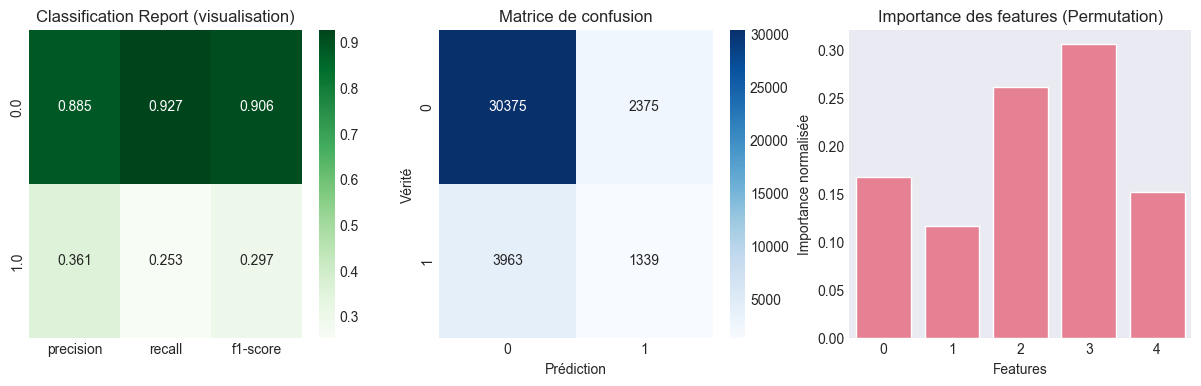

In [12]:
samples = preprocessing(data=data_diabetes, test_size=0.15, validation_size=0.15)

cols = [0, 1, 3, 13, 18]
samples.X_train = samples.X_train[:, cols]
samples.X_test = samples.X_test[:, cols]
samples.X_validation = samples.X_validation[:, cols]

model = KNNModel()
model.train(x=samples.X_train, y=samples.y_train)
model.benchmark(x=samples.X_test, y=samples.y_test)

There isn't any improvement in the model but the training and prediction is much faster. 
We can conclude that the diabete dataset is more complex than the spam dataset : we need a more complex algorithm than KNN.   

# Neural network : MLP

In [13]:
from src.nn_interface import MLPModel

samples = preprocessing(data=data_diabetes, test_size=0.15, validation_size=0.15)
model = MLPModel(input_size=21, epochs=15)
model.train(samples)

epoch: 1 	training Loss: 0.985176 
Validation loss improved → new best = 0.929588
epoch: 2 	training Loss: 0.956276 
Validation loss improved → new best = 0.929136
epoch: 3 	training Loss: 0.950584 
Validation loss improved → new best = 0.924324
epoch: 4 	training Loss: 0.947359 
No improvement in validation loss (current: 0.925106, best: 0.924324) → reverting weights
epoch: 5 	training Loss: 0.946578 
Validation loss improved → new best = 0.922625
epoch: 6 	training Loss: 0.944780 
No improvement in validation loss (current: 0.931657, best: 0.922625) → reverting weights
epoch: 7 	training Loss: 0.942007 
No improvement in validation loss (current: 0.927268, best: 0.922625) → reverting weights
epoch: 8 	training Loss: 0.939926 
Validation loss improved → new best = 0.920960
epoch: 9 	training Loss: 0.939375 
No improvement in validation loss (current: 0.924353, best: 0.920960) → reverting weights
epoch: 10 	training Loss: 0.938849 
No improvement in validation loss (current: 0.923941, 

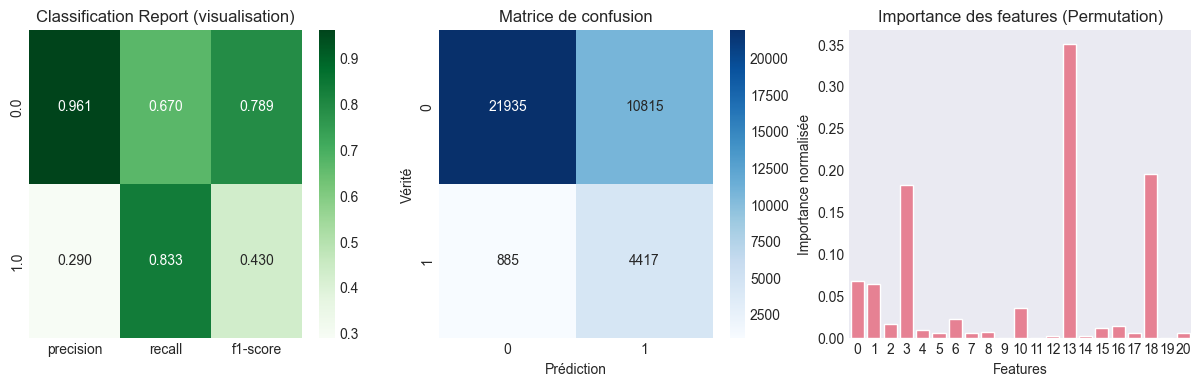

In [14]:
model.benchmark(samples.X_test, samples.y_test)

We decide to use a MLP with 3 hidden layers to tackle this complex dataset as neural networks are very powerful.  
We observe far better results than for KNN : precision for diabetic people is around 29% but recall is approx 83%. That means that the algorithm detects 83% of the diabetic cases which is a pretty good result. Indeed, eventhough the algorithm classifies non-diabetic people as diabetic people this doesn't have dramatic consequences. On the contrary, if diabetic people are classified as non-diabetic, it can have problematic consequences.
That's why we prefer to have a high recall and a low precision for class 1 than a low recall and a high precision. 
Moreover the precision for diabetic people is very high (96%) and recall remains high (67%).  
We can note that some features seem to have played a bigger role than others when predicting : GenHlth (36% of feature importance), BMI (20%) and age (18%).

However if we compare with the spam dataset, the training is much longer because of the amount of data but the loss doesn't decrease that much : the MLP struggles to reach excellent performances, only 15 epochs are sufficient


=== Analyse SHAP - MLP PyTorch ===
Modèle en mode évaluation
Sélection de 100 samples pour le background...
Limitation à 200 samples (sur 38052)...
Création du KernelExplainer...
Calcul des SHAP values sur 200 samples...
(Cela peut prendre 2-3 minutes...)


100%|██████████| 200/200 [00:17<00:00, 11.34it/s]


SHAP values calculées ! Shape: (200, 21)
Génération des graphiques...


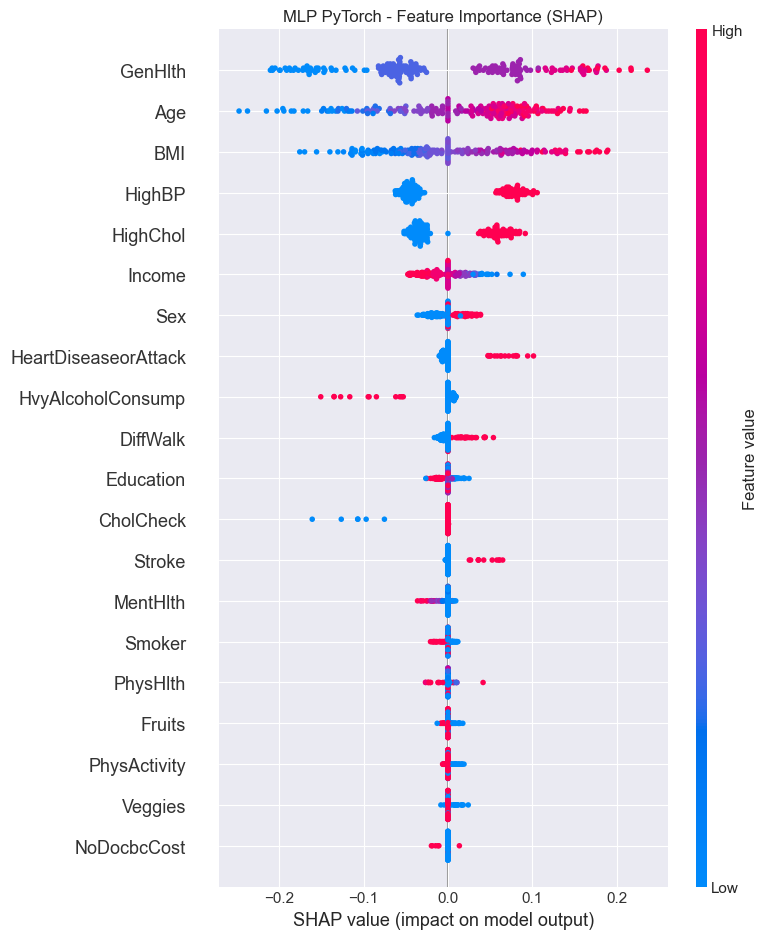

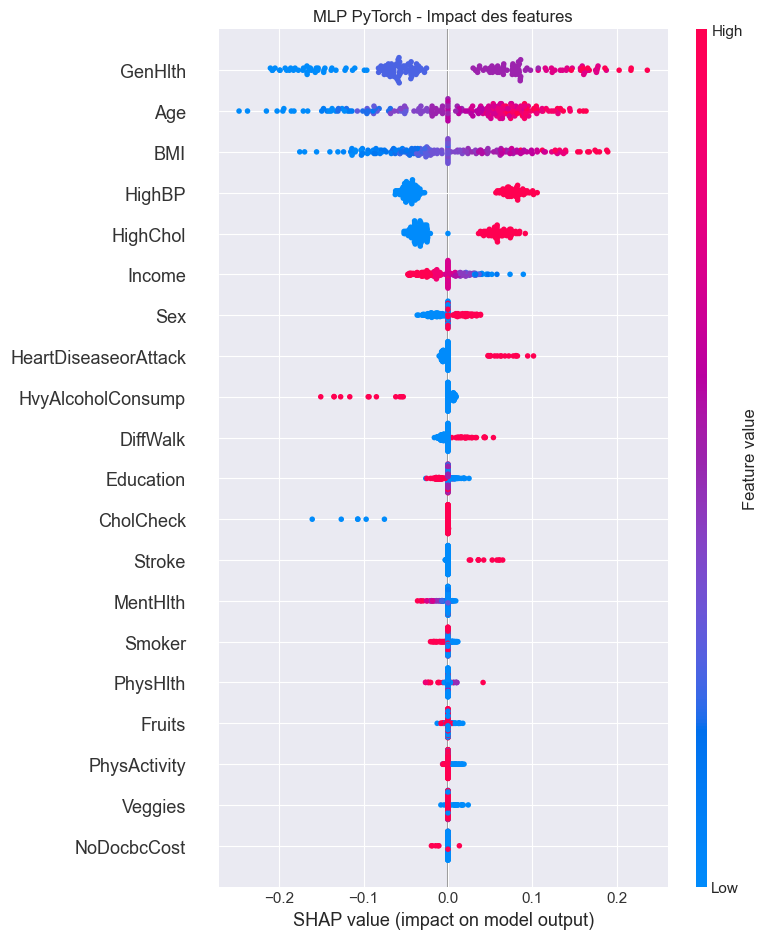


Génération du WaterFall Plot pour l'échantillon 0...


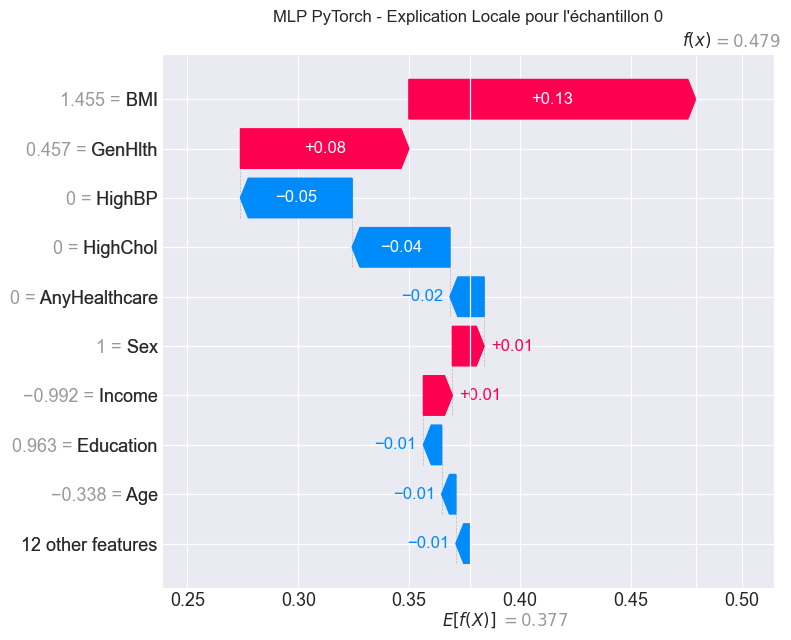

✅ Analyse SHAP MLP terminée


In [17]:
mlp_shap, mlp_explainer = model.explain(
    model=model.model,
    X_train=samples.X_train,
    X_test=samples.X_test,
    feature_names=feature_names,
    idx_explained = 100,
    n_background=100,
    n_test_samples=200
)

In [18]:
samples = preprocessing(data=data_diabetes, test_size=0.15, validation_size=0.15)

cols = [0, 1, 3, 13, 18]
samples.X_train = samples.X_train[:, cols]
samples.X_test = samples.X_test[:, cols]
samples.X_validation = samples.X_validation[:, cols]


model = MLPModel(input_size=5, epochs=15)
model.train(samples)

epoch: 1 	training Loss: 0.991369 
Validation loss improved → new best = 0.944709
epoch: 2 	training Loss: 0.970367 
Validation loss improved → new best = 0.941854
epoch: 3 	training Loss: 0.967643 
Validation loss improved → new best = 0.941750
epoch: 4 	training Loss: 0.964384 
No improvement in validation loss (current: 0.944601, best: 0.941750) → reverting weights
epoch: 5 	training Loss: 0.961866 
Validation loss improved → new best = 0.939169
epoch: 6 	training Loss: 0.963520 
No improvement in validation loss (current: 0.940962, best: 0.939169) → reverting weights
epoch: 7 	training Loss: 0.961870 
No improvement in validation loss (current: 0.948735, best: 0.939169) → reverting weights
epoch: 8 	training Loss: 0.960423 
No improvement in validation loss (current: 0.948258, best: 0.939169) → reverting weights
epoch: 9 	training Loss: 0.961103 
No improvement in validation loss (current: 0.943829, best: 0.939169) → reverting weights
epoch: 10 	training Loss: 0.960767 
No improvem

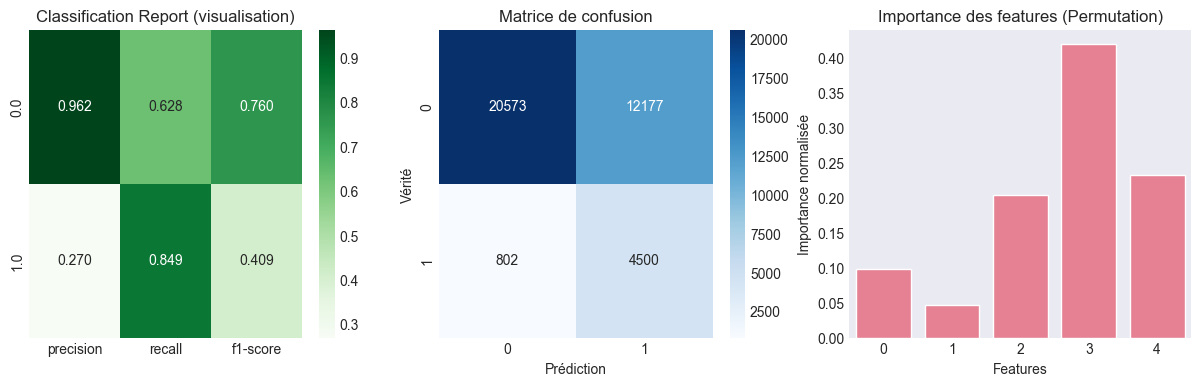

In [19]:
model.benchmark(samples.X_test, samples.y_test)

We don't see any improvement in our model : we have the same results as before.

# Random Forest

In [25]:
from src.RForest import RForest

samples = preprocessing(data=data_diabetes, test_size=0.3, validation_size=0.1)

model_rf = RForest()
MODEL_PATH = "model_weights/best_random_forest_1.joblib"

# Tenter de charger le modèle
if not model_rf.load_model(MODEL_PATH):
    # Si le chargement échoue (première fois ou fichier manquant), entraîner
    print("Modèle non trouvé, lancement de l'entraînement...")
    model_rf.train(samples.X_train, samples.y_train)
    # Sauvegarder après l'entraînement
    model_rf.save_model(MODEL_PATH)
else:
    print("Modèle déjà entraîné chargé.")

 Modèle Random Forest chargé depuis best_random_forest_1.joblib
Modèle déjà entraîné chargé.


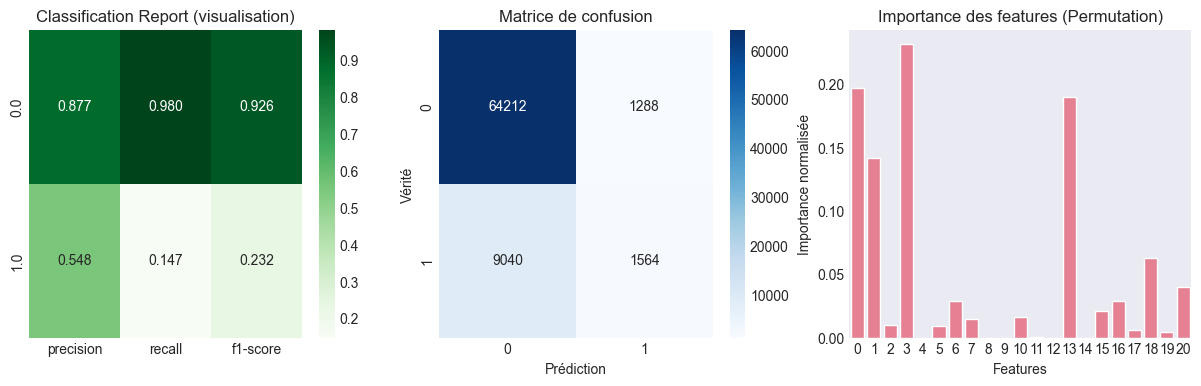

In [24]:
model_rf.benchmark(x=samples.X_test, y=samples.y_test)

The Random Forest isn't effective at all to tackle this problem even when we optimize the hyperparameters by using a Grid Search. Recall for class 1 is around 15% which is even worse than for the KNN model...  
However an interesting thing that we can notice is that the MLP and the Random Forest use some of the same features to predict the results  : BMI, GenHlth and age. The other important features are HighBP and HighChol.

In [ ]:
samples = preprocessing(data=data_diabetes, test_size=0.15, validation_size=0.15)

cols = [0, 1, 3, 13, 18]
samples.X_train = samples.X_train[:, cols]
samples.X_test = samples.X_test[:, cols]
samples.X_validation = samples.X_validation[:, cols]


model = RForest()
model.train(x=samples.X_train, y=samples.y_train)
model.benchmark(x=samples.X_test, y=samples.y_test)

The model was way more faster to train with only these 5 features. However the results are not better than before : the recall is even worse than the previous model. 

# Linear SVC

In [26]:
from src.kernel_methods import LinearSVC_

samples = preprocessing(data=data_diabetes, test_size=0.3, validation_size=0.1)
model = LinearSVC_()
model.train(x=samples.X_train, y=samples.y_train)

Best hyperparameters found with Grid Search: {'C': 100}


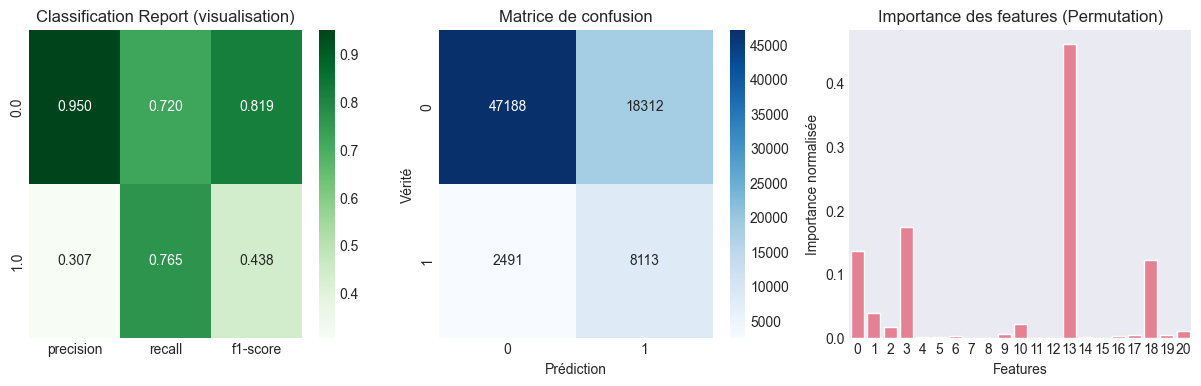

In [27]:
model.benchmark(x=samples.X_test, y=samples.y_test)

To optimise the hyperparameters used by the LinearSVC model we use a Grid Search. 
The LinearSVC model we use here is almost as good as the MLP model we used above : we have a recall of 76.5% for class 1 while still having a precision of 85% and a recall of 72% for class 0.  
We notice that this model uses less features than the others. However is has also important features in common (BMI, GenHlth, age) with the MLP and the KNN and it uses HighBP like RandomForest.  

We decide once again to select only the most important features to train our model once again. 

In [ ]:
samples = preprocessing(data=data_diabetes, test_size=0.15, validation_size=0.15)

cols = [0, 1, 2, 3, 10, 13, 18]
samples.X_train = samples.X_train[:, cols]
samples.X_test = samples.X_test[:, cols]
samples.X_validation = samples.X_validation[:, cols]


model = LinearSVC_()
model.train(x=samples.X_train, y=samples.y_train)
model.benchmark(x=samples.X_test, y=samples.y_test)

The feature selection doesn't improve the results either.

## Conclusion : 

The model for diabetes being more complex than the model for spams, the KNN and Random Forest algorithms are not useful anymore.  
The neural networks and LinearSVC, eventhough they are not perfect, achieve very good recall scores for class 1 (80% and 76%) while maintaining high precision and recall scores for class 0.  
Thus, for this diabete problem, the neural network is the best model.   
Note that we can increase the recall for class 1 by playing on the decision threshold (person is classified as diabetic when probability is above 0.3 for example). 
Moreover we decided to do some selection features to keep only the most important features : this doesn't improve the models but it makes the models clearer and more easily interpretable.